# Load dependencies

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [2]:
device = torch.device('cuda')

In [3]:
#### from https://github.com/gngdb/pytorch-pca/tree/main ####
def svd_flip(u, v):
    # columns of u, rows of v
    max_abs_cols = torch.argmax(torch.abs(u), 0)
    i = torch.arange(u.shape[1]).to(u.device)
    signs = torch.sign(u[max_abs_cols, i])
    u *= signs
    v *= signs.view(-1, 1)
    return u, v

class TorchPCA(nn.Module):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components

    #@torch.no_grad()
    def fit(self, X):
        n, d = X.size()
        if self.n_components is not None:
            d = min(self.n_components, d)
        self.register_buffer("mean_", X.mean(0, keepdim=True))
        Z = X - self.mean_ # center
        U, S, Vh = torch.linalg.svd(Z, full_matrices=False)
        Vt = Vh
        U, Vt = svd_flip(U, Vt)
        self.register_buffer("components_", Vt[:d])
        return self

    def forward(self, X):
        return self.transform(X)

    def transform(self, X):
        assert hasattr(self, "components_"), "PCA must be fit before use."
        return torch.matmul(X - self.mean_, self.components_.t())

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, Y):
        assert hasattr(self, "components_"), "PCA must be fit before use."
        return torch.matmul(Y, self.components_) + self.mean_

# Load data

In [4]:
X_A = pd.read_csv('../preprocessing/XA4Wang.csv') # ,index_col=0 in MPS
X_B = pd.read_csv('../preprocessing/X_wang.csv') # ,index_col=0 in MPS
Y_A = pd.read_csv('../preprocessing/Y_A.csv',index_col=0)

In [5]:
# X_A = pd.read_csv('../preprocessing/X_A.csv',index_col=0)
# X_B = pd.read_csv('../preprocessing/X_B.csv',index_col=0)
# Y_A = pd.read_csv('../preprocessing/Y_A.csv',index_col=0)
# lean_control_chips = pd.read_csv('../preprocessing/chip_lean_controls_indices.csv',index_col=0)
# fatty_control_chips = pd.read_csv('../preprocessing/chip_fatty_controls_indices.csv',index_col=0)

In [6]:
# get total variance of X_A
varA = np.var(X_A,axis=0).sum()
print(varA)

211.8723706539328


# Get PCA loadings

In [7]:
# initialize a PCA object with the largest value of n_components you can
pca = PCA()
# fit your PCA object to your data
pca.fit(X_B)
# transform your data into PCA space
Z_B = pca.transform(X_B)

Text(0.5, 1.0, 'in-vitro model PC space')

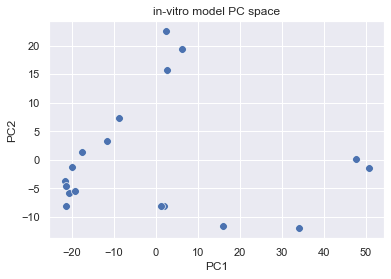

In [8]:
pca_data = pd.DataFrame(data={'PC1':Z_B[:,0], 'PC2':Z_B[:,1]})
# pca_data = pd.concat([pca_data,pd.DataFrame(data={'PC1':Z_A_B[:,0], 'PC2':Z_A_B[:,1]})])
# pca_data['dataset'] = ['in-vitro model' for i in range(Z_B.shape[0])] + ['humans' for i in range(Z_A_B.shape[0])]
# plot our PCA transformed data using sns.scatterplot() (set hue = target)
sns.scatterplot(data = pca_data , x = 'PC1',y = 'PC2', s =60 , palette= 'icefire')
plt.title('in-vitro model PC space')

In [9]:
loadings = pca.components_
print(loadings.shape)

(18, 24806)


In [10]:
Z_A_B = np.dot(X_A,loadings.T)
varAB = np.var(Z_A_B,axis=0).sum()
print('The explained variance of the human data in the PC-space of liver chip is {:.2f} %'.format(100*varAB/varA))

The explained variance of the human data in the PC-space of liver chip is 7.12 %


In [11]:
original_explained = 100*varAB/varA

# Initialize perturbation as a small random dX

In [12]:
XB = torch.tensor(X_B.values).float().to(device)
XA = torch.tensor(X_A.values).float().to(device)

Sample 0 Iteration=0, loss=-0.0688, explained_variance=7.22%
Sample 0 Iteration=200, loss=-0.1974, explained_variance=19.86%
Sample 0 Iteration=400, loss=-0.1956, explained_variance=19.89%
Sample 0 Iteration=600, loss=-0.1963, explained_variance=19.89%
Sample 0 Iteration=800, loss=-0.1964, explained_variance=19.89%
Sample 0 Iteration=999, loss=-0.1961, explained_variance=19.89%
The new explained variance of the human data in the PC-space of liver chip is 19.64 %
Sample 1 Iteration=0, loss=-0.0688, explained_variance=7.22%
Sample 1 Iteration=200, loss=-0.1974, explained_variance=19.86%
Sample 1 Iteration=400, loss=-0.1946, explained_variance=19.69%
Sample 1 Iteration=600, loss=-0.1941, explained_variance=19.88%
Sample 1 Iteration=800, loss=-0.1938, explained_variance=19.86%
Sample 1 Iteration=999, loss=-0.1934, explained_variance=19.73%
The new explained variance of the human data in the PC-space of liver chip is 19.51 %
Sample 2 Iteration=0, loss=-0.0688, explained_variance=7.22%
Sampl

Sample 17 Iteration=800, loss=-0.1900, explained_variance=19.22%
Sample 17 Iteration=999, loss=-0.1974, explained_variance=19.90%
The new explained variance of the human data in the PC-space of liver chip is 19.64 %


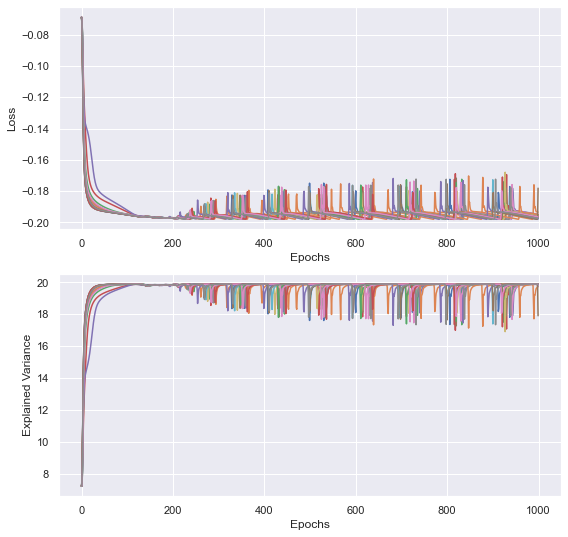

In [13]:
new_vars = []
df_pert = pd.DataFrame({})
fig, axs = plt.subplots(2,figsize=(9, 9))
for j in range(XB.shape[0]):
    XB_start = XB[j,:].view(1,XB.shape[1])
    #XB_start = torch.mean(XB,0,keepdim= True)
    dX = np.random.normal(X_B.mean(0).values,X_B.std(0).values,size=(1,X_B.shape[1]))
    dX = torch.tensor(dX).float().to(device)
    Input_pert = torch.nn.Parameter(dX, requires_grad = True)
    Input_pert.retain_grad()
    optimizer = torch.optim.Adam([Input_pert],lr= 0.1,weight_decay=0)


    loss_all = []
    exp_var_all = []
    iters = 1000
    torch.autograd.set_detect_anomaly(True)
    #j=0
    for i in range(iters):
        optimizer.zero_grad()
        Xstar = XB_start + Input_pert
        X = torch.concat((XB,Xstar),0)
        U,S,V = torch.svd(X)
        Z_A_B = torch.matmul(XA,V)
        varAB = torch.var(Z_A_B,axis=0).sum()

        loss = - varAB/varA
        loss = loss + 1e-6 * torch.sum(torch.abs(Input_pert))
        loss.backward()
        optimizer.step()

        exp_var = 100 * varAB/varA
        exp_var = exp_var.item()
        loss_all.append(loss.item())
        exp_var_all.append(exp_var)
        if i % 200 == 0 :
            outString = 'Sample {:.0f} Iteration={:.0f}'.format(j,i)
            outString += ', loss={:.4f}'.format(loss.item())
            outString += ', explained_variance={:.2f}%'.format(exp_var)
            print(outString)
    outString = 'Sample {:.0f} Iteration={:.0f}'.format(j,i)
    outString += ', loss={:.4f}'.format(loss.item())
    outString += ', explained_variance={:.2f}%'.format(exp_var)
    print(outString)
    dx = pd.DataFrame(Input_pert.detach().cpu().numpy())
    dx.columns = X_B.columns.values
    df_pert = df_pert.append(dx)
    axs[0].plot(range(iters),loss_all)
    axs[1].plot(range(iters),exp_var_all)
    axs[0].set(xlabel='Epochs', ylabel='Loss')
    axs[1].set(xlabel='Epochs', ylabel='Explained Variance')
    #plt.plot(range(iters),exp_var_all)
    
    Xstar = XB_start + Input_pert
    X = torch.concat((XB,Xstar),0)
    X = X.detach().cpu().numpy()
    # initialize a PCA object with the largest value of n_components you can
    pca = PCA()
    # fit your PCA object to your data
    pca.fit(X)
    loadings = pca.components_
    Z_A_B = np.dot(X_A,loadings.T)
    varAB = np.var(Z_A_B,axis=0).sum()
    print('The new explained variance of the human data in the PC-space of liver chip is {:.2f} %'.format(100*varAB/varA))
    new_vars.append(100*varAB/varA)

In [14]:
df_pert.index = [i for i in range(XB.shape[0])]

In [15]:
df_pert

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,OR4G2P,DDX51,YBX2,NANOS3,ISLR,TMEM95,C1R,PRKACA,CTAGE4,CTAGE8
0,-0.084438,0.064240,0.000399,0.064346,0.030162,0.186060,0.108749,0.327955,-0.084886,0.094695,...,-0.003455,-0.054355,-0.276149,0.036602,0.564338,-0.004963,0.091296,0.085506,0.204055,0.145614
1,0.080162,0.009494,0.094613,0.098774,0.072046,0.249474,0.211344,0.514069,-0.128677,0.094643,...,0.044337,-0.078155,-0.522109,0.034896,0.799229,-0.002508,0.199150,0.109266,0.248216,0.252872
2,-0.066389,0.054208,-0.002230,0.065901,0.029010,0.195031,0.114218,0.339179,-0.081332,0.091506,...,-0.003469,-0.056301,-0.285083,0.037946,0.572259,-0.005851,0.093577,0.087610,0.209234,0.147216
3,-0.108977,0.083194,-0.002618,0.084508,0.038733,0.229002,0.143983,0.425115,-0.104379,0.122129,...,-0.000421,-0.071217,-0.360527,0.046636,0.719307,-0.002477,0.131608,0.107591,0.258117,0.190796
4,0.074726,-0.069558,-0.002322,-0.098778,-0.052350,-0.251522,-0.170158,-0.471061,0.120368,-0.122227,...,0.009053,0.073441,0.406817,-0.065521,-0.790933,0.001802,-0.165845,-0.114457,-0.289958,-0.208871
5,-0.121192,0.077835,-0.010596,0.058806,0.022781,0.166290,0.092827,0.312790,-0.075867,0.101340,...,0.001060,-0.052107,-0.265337,0.035789,0.544214,-0.003556,0.075308,0.082896,0.195614,0.139872
6,-0.092239,0.080800,-0.002867,0.092167,0.044940,0.224713,0.153355,0.437493,-0.116420,0.120733,...,-0.005097,-0.069622,-0.378767,0.054433,0.750904,-0.006325,0.151647,0.108628,0.273188,0.196432
7,0.037769,-0.050821,-0.011776,-0.080660,-0.042533,-0.240352,-0.141099,-0.395855,0.108362,-0.095186,...,0.006214,0.063332,0.334395,-0.046072,-0.665229,0.004307,-0.122046,-0.096481,-0.240570,-0.172172
8,0.079058,-0.062105,0.001560,-0.066205,-0.033466,-0.207119,-0.112794,-0.348449,0.090974,-0.096858,...,0.000859,0.054043,0.291347,-0.039989,-0.596307,0.005485,-0.088207,-0.092177,-0.216722,-0.151316
9,-0.035334,0.025177,0.002603,0.017781,0.015277,0.090056,0.030739,0.124301,-0.027299,0.037256,...,0.002992,-0.013453,-0.104327,0.012634,0.210685,-0.003187,0.003278,0.033724,0.071159,0.051788


In [16]:
df_pert.to_csv('../results/optimized_mps/dx_wang.csv')

In [17]:
df_results = pd.DataFrame({'orginal_var_exp':np.repeat(original_explained,len(new_vars)),
                           'new_var_exp':np.array(new_vars),
                           'dataset':np.repeat('Wang',len(new_vars))})
df_results

,orginal_var_exp,new_var_exp,dataset
0,7.121277,19.635392,Wang
1,7.121277,19.508207,Wang
2,7.121277,19.636349,Wang
3,7.121277,19.629357,Wang
4,7.121277,19.632493,Wang
5,7.121277,19.637286,Wang
6,7.121277,19.631310,Wang
7,7.121277,19.630954,Wang
8,7.121277,19.641753,Wang
9,7.121277,19.640564,Wang


In [18]:
df_results.to_csv('../results/optimized_mps/optimized_results_wang.csv')

### Validate with sklearn

In [19]:
Xstar = XB + torch.tensor(df_pert.values).to(device)
X = torch.concat((XB,Xstar),0)
X = X.detach().cpu().numpy()

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

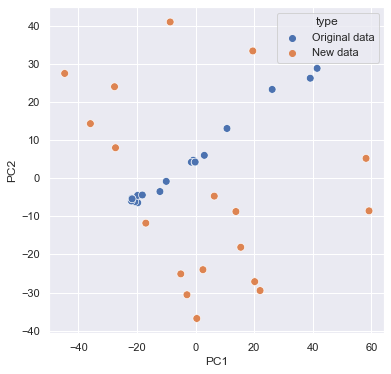

In [20]:
# initialize a PCA object with the largest value of n_components you can
pca = PCA()
# fit your PCA object to your data
pca.fit(X)
# transform your data into PCA space
Z_B = pca.transform(X)
pca_data = pd.DataFrame(data={'PC1':Z_B[:,0], 'PC2':Z_B[:,1]})
# plot our PCA transformed data using sns.scatterplot() (set hue = target)
pca_data["type"] = ['Original data' for i in range(XB.shape[0])] + ['New data' for i in range(XB.shape[0])]
plt.figure(figsize=(6, 6))
sns.scatterplot(data = pca_data , x = 'PC1',y = 'PC2' , s =60 ,hue='type')

In [21]:
loadings = pca.components_
print(loadings.shape)
Z_A_B = np.dot(X_A,loadings.T)
varAB = np.var(Z_A_B,axis=0).sum()
print('The explained variance of the human data in the PC-space of liver chip is {:.2f} %'.format(100*varAB/varA))

(36, 24806)
The explained variance of the human data in the PC-space of liver chip is 33.41 %


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

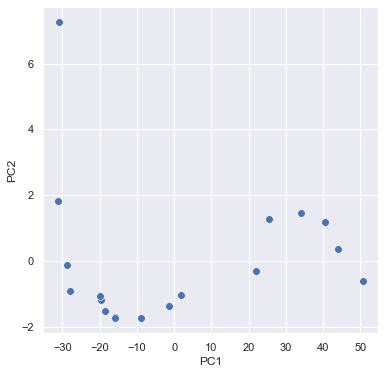

In [22]:
# initialize a PCA object with the largest value of n_components you can
pca = PCA()
# fit your PCA object to your data
pca.fit(df_pert.values)
# transform your data into PCA space
Z = pca.transform(df_pert.values)
pca_data = pd.DataFrame(data={'PC1':Z[:,0], 'PC2':Z[:,1]})
plt.figure(figsize=(6, 6))
sns.scatterplot(data = pca_data , x = 'PC1',y = 'PC2' , s =60 )